In [1]:
import numpy as np
import pandas as pd
import os
import pickle

# Other packages
import analyzer.loaders.cremona.utils as u
import analyzer.loaders.cremona as cremona
import analyzer.loaders.hmfundacion.hmfundacion as hmfundacion
from analyzer.utils import store_json, change_SaO2
import analyzer.dataset as ds

import shap

# import plotly.graph_objects as go
# import plotly.io as pio
# pio.renderers.default='browser'

In [2]:
import matplotlib.pyplot as plt

## Load Model and Data

Select model type.  
- **model_type** = 'mortality' or 'infection'
- **model_lab** = 'with_lab' or 'without_lab'

In [3]:
model_type = 'mortality'
model_lab = 'with_lab'

assert model_type in('mortality','infection'), "Invalid outcome"
assert model_lab in('with_lab','without_lab'), "Invalid lab specification"

Set paths for data/model loading

In [4]:
website_path = '/Users/hollywiberg/git/website/'
path_cremona = '/Users/hollywiberg/Dropbox (MIT)/COVID_risk/covid19_cremona/data/'
path_hm = '/Users/hollywiberg/Dropbox (MIT)/COVID_risk/covid19_hmfoundation/'
data_path = '/Users/hollywiberg/Dropbox (MIT)/COVID_risk/covid19_clean_data/'

Load model corresponding to *model_type* and *model_lab*.

Trying to unpickle estimator KNNImputer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
This figure was saved with matplotlib version 3.1.2 and is unlikely to function correctly.


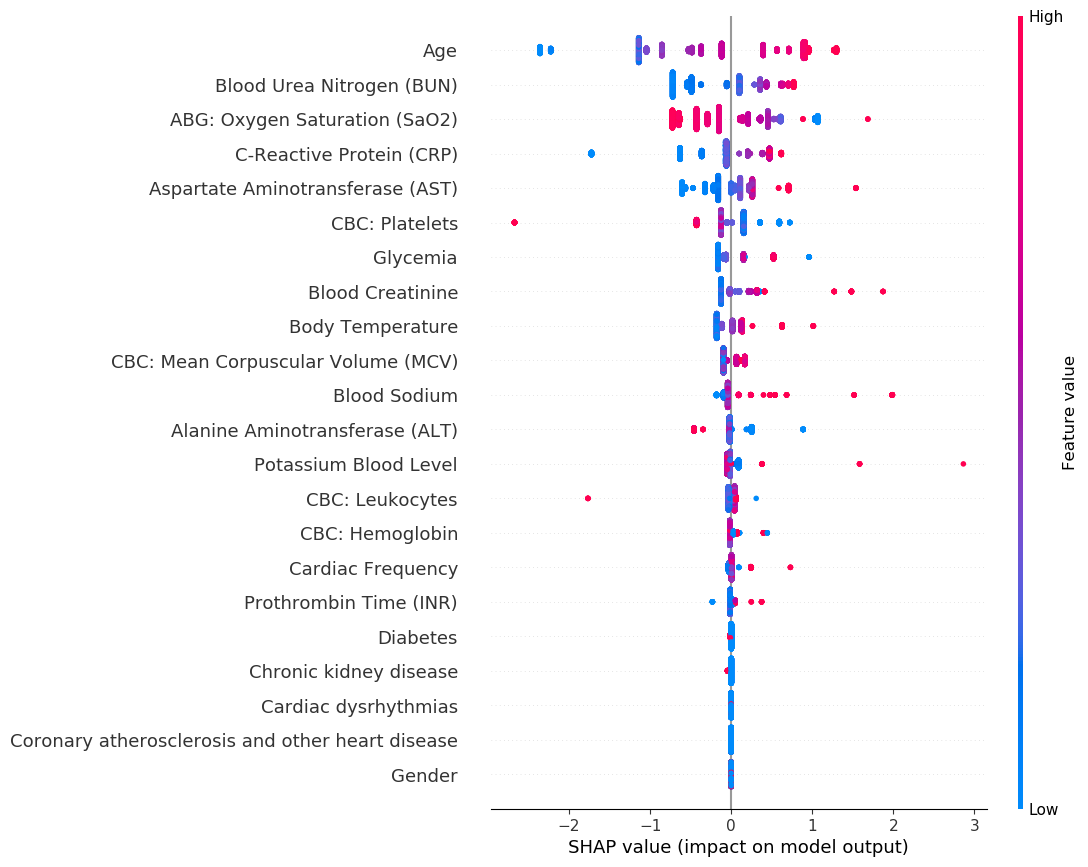

In [5]:
with open(website_path+'assets/risk_calculators/'+model_type+'/model_'+model_lab+'.pkl', 'rb') as file:
    model_file = pickle.load(file)
    
model = model_file['model']
features = model_file['json']
columns = model_file['columns']
imputer= model_file['imputer']

In [6]:
data = pd.read_csv(data_path+model_type+"_"+model_lab+"/train.csv")
if model_type == "mortality":
    X = data.drop(["Unnamed: 0", "Outcome"], axis=1, inplace = False)
    y = data["Outcome"]
else:
    X = data.drop(["NOSOLOGICO","Swab"], axis=1, inplace = False)
    y = data["Swab"]

In [7]:
from sklearn.metrics import roc_curve, auc, accuracy_score

pred_Y = model.predict_proba(X)[:, 1]

is_fpr, is_tpr, thresh = roc_curve(y, pred_Y)

accuracy_scores = []
for t in thresh:
    accuracy_scores.append(accuracy_score(y, 
                                         [1 if m > t else 0 for m in pred_Y]))

In [8]:
auc(is_fpr, is_tpr)

0.928154496591505

In [9]:
X

,Age,Gender,ABG: Oxygen Saturation (SaO2),Cardiac Frequency,Alanine Aminotransferase (ALT),Blood Creatinine,Blood Sodium,Blood Urea Nitrogen (BUN),Body Temperature,C-Reactive Protein (CRP),...,CBC: Mean Corpuscular Volume (MCV),Aspartate Aminotransferase (AST),CBC: Platelets,Cardiac dysrhythmias,Chronic kidney disease,Coronary atherosclerosis and other heart disease,Diabetes,Glycemia,Potassium Blood Level,Prothrombin Time (INR)
0,70.0,0.0,87.60,87.2,54.0,0.84,129.0,22.000000,97.31,191.47,...,82.54,59.0,356.0,0.0,0.0,0.0,0.0,113.0,3.20,1.250
1,63.0,0.0,94.00,113.0,30.7,1.29,135.4,24.485981,97.88,180.40,...,85.10,37.7,245.0,0.0,0.0,0.0,0.0,121.3,4.64,1.180
2,90.0,1.0,93.00,77.0,22.1,0.88,139.2,14.345795,95.18,158.80,...,96.10,16.5,264.0,0.0,0.0,0.0,0.0,110.0,4.32,1.560
3,76.0,0.0,90.80,82.3,41.0,1.41,133.0,29.000000,102.47,118.97,...,87.50,36.0,119.0,0.0,0.0,0.0,0.0,245.0,4.70,1.010
4,81.0,0.0,92.22,105.0,73.0,2.10,144.0,79.000000,101.48,222.25,...,95.20,104.0,306.0,0.0,0.0,0.0,0.0,123.0,4.50,0.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,51.0,0.0,85.94,97.0,32.0,1.08,137.0,16.000000,100.04,12.27,...,79.20,22.0,118.0,0.0,0.0,0.0,0.0,179.0,3.70,1.060
2543,53.0,0.0,95.60,99.2,45.0,1.06,137.0,13.000000,97.16,28.53,...,91.10,37.0,182.0,0.0,0.0,0.0,0.0,95.0,3.80,0.988
2544,63.0,1.0,91.00,89.0,34.1,0.71,139.0,15.420561,98.60,22.77,...,91.30,39.0,189.0,0.0,0.0,0.0,1.0,128.9,3.69,1.302
2545,52.0,0.0,97.00,86.0,53.2,1.09,139.1,17.289720,100.40,103.40,...,86.00,41.1,158.0,1.0,0.0,0.0,0.0,105.0,3.98,1.080


## Evaluate Model with SHAP

In [10]:
shap.initjs()

##### Calculate SHAP values (for each observation x feature)

In [11]:
shap.initjs()

explainer = shap.TreeExplainer(model);
shap_values = explainer.shap_values(X);

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


##### Summarize SHAP values across all features
This acts as an alterative to the standard variable importance plots. Higher SHAP values translate to higher probability of mortality.

In [12]:
X.query("Age > 20")

,Age,Gender,ABG: Oxygen Saturation (SaO2),Cardiac Frequency,Alanine Aminotransferase (ALT),Blood Creatinine,Blood Sodium,Blood Urea Nitrogen (BUN),Body Temperature,C-Reactive Protein (CRP),...,CBC: Mean Corpuscular Volume (MCV),Aspartate Aminotransferase (AST),CBC: Platelets,Cardiac dysrhythmias,Chronic kidney disease,Coronary atherosclerosis and other heart disease,Diabetes,Glycemia,Potassium Blood Level,Prothrombin Time (INR)
0,70.0,0.0,87.60,87.2,54.0,0.84,129.0,22.000000,97.31,191.47,...,82.54,59.0,356.0,0.0,0.0,0.0,0.0,113.0,3.20,1.250
1,63.0,0.0,94.00,113.0,30.7,1.29,135.4,24.485981,97.88,180.40,...,85.10,37.7,245.0,0.0,0.0,0.0,0.0,121.3,4.64,1.180
2,90.0,1.0,93.00,77.0,22.1,0.88,139.2,14.345795,95.18,158.80,...,96.10,16.5,264.0,0.0,0.0,0.0,0.0,110.0,4.32,1.560
3,76.0,0.0,90.80,82.3,41.0,1.41,133.0,29.000000,102.47,118.97,...,87.50,36.0,119.0,0.0,0.0,0.0,0.0,245.0,4.70,1.010
4,81.0,0.0,92.22,105.0,73.0,2.10,144.0,79.000000,101.48,222.25,...,95.20,104.0,306.0,0.0,0.0,0.0,0.0,123.0,4.50,0.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,51.0,0.0,85.94,97.0,32.0,1.08,137.0,16.000000,100.04,12.27,...,79.20,22.0,118.0,0.0,0.0,0.0,0.0,179.0,3.70,1.060
2543,53.0,0.0,95.60,99.2,45.0,1.06,137.0,13.000000,97.16,28.53,...,91.10,37.0,182.0,0.0,0.0,0.0,0.0,95.0,3.80,0.988
2544,63.0,1.0,91.00,89.0,34.1,0.71,139.0,15.420561,98.60,22.77,...,91.30,39.0,189.0,0.0,0.0,0.0,1.0,128.9,3.69,1.302
2545,52.0,0.0,97.00,86.0,53.2,1.09,139.1,17.289720,100.40,103.40,...,86.00,41.1,158.0,1.0,0.0,0.0,0.0,105.0,3.98,1.080


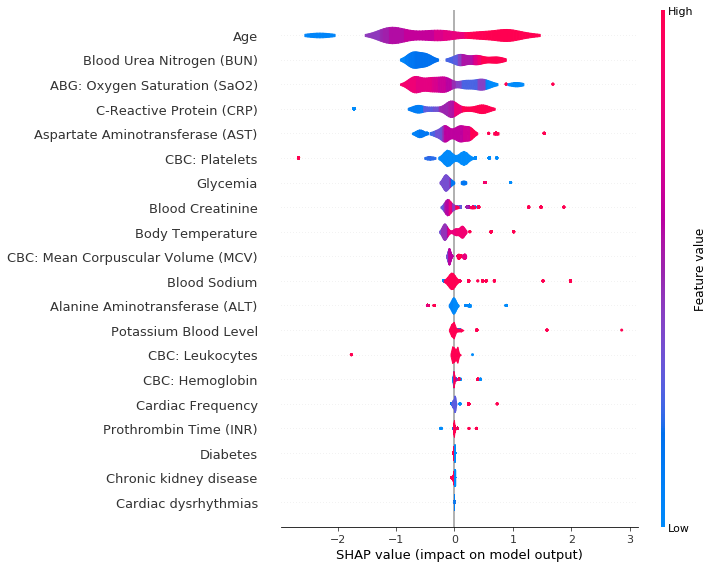

In [19]:
# shap.summary_plot(shap_values, X).
# X_filter = X.query("Age > 50")
X_filter = X
shap_values_filter = explainer.shap_values(X_filter);
shap.summary_plot(shap_values_filter, X_filter,show=False,plot_type="violin")
f = plt.gcf()
# f.savefig('../results/'+model_type+'/model_'+model_lab+'/summary_plot.png', bbox_inches='tight')

##### Deep-dive into individual features
For a given feature, see how the SHAP varies across its possible values. The interaction_index lets you choose a secondary index to visualize. If omitted, it will automatically find the variable with the highest interaction.

invalid value encountered in true_divide
invalid value encountered in true_divide


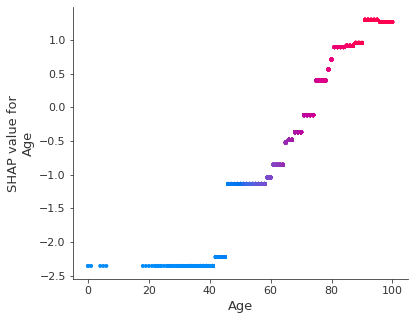

In [66]:
shap.dependence_plot("Age", shap_values, X)

##### Evaluate drivers of individual predictions 
Select index j for prediction to generate.

In [51]:
# shap.force_plot(explainer.expected_value, shap_values[1:10,:], X.iloc[[1:10,:]])
j=100
X_new = X.iloc[[j]]
X_new
print(X_new)
shap_new = explainer.shap_values(X_new)
shap.force_plot(explainer.expected_value, shap_new, X_new , link="logit")

      Age  Gender  ABG: Oxygen Saturation (SaO2)  Cardiac Frequency  \
100  46.0     0.0                           91.0              109.0   

     Alanine Aminotransferase (ALT)  Blood Creatinine  Blood Sodium  \
100                            77.8              1.05         137.6   

     Blood Urea Nitrogen (BUN)  Body Temperature  C-Reactive Protein (CRP)  \
100                  14.205607              99.5                     160.2   

     ...  CBC: Mean Corpuscular Volume (MCV)  \
100  ...                                87.6   

     Aspartate Aminotransferase (AST)  CBC: Platelets  Cardiac dysrhythmias  \
100                              68.1           229.0                   0.0   

     Chronic kidney disease  Coronary atherosclerosis and other heart disease  \
100                     0.0                                               1.0   

     Diabetes  Glycemia  Potassium Blood Level  Prothrombin Time (INR)  
100       0.0     144.4                    4.2                   

As an alternative view, you can trace a 3D plot of the values and their impact on the prediction.